In [2]:
include("../Inversion/Plot.jl")
include("../Inversion/KalmanInversion.jl")
include("Linear.jl")

forward_aug (generic function with 1 method)

# Two Parameter Linear Inverse Problems

Consider the 2-parameter linear inverse problem
$$y = G\theta + \eta.$$
with $\eta \sim \mathcal{N}(0, 0.1^2I)$. We explore the following three scenarios

#### non-singular (well-determined) system (NS) 
   $$
   y = \begin{bmatrix}
        3 \\
        7 
       \end{bmatrix} \quad
       G = \begin{bmatrix}
        1 & 2\\
        3 & 4
    \end{bmatrix} \quad
    \theta_{ref} = \begin{bmatrix}
        1 \\
        1 
       \end{bmatrix};
   $$ 
   
#### over-determined system (OD)
$$ y = \begin{bmatrix}
        3 \\
        7 \\
        10
       \end{bmatrix} \quad
       G = \begin{bmatrix}
        1 & 2\\
        3 & 4 \\
        5 & 6
    \end{bmatrix} \quad
    \theta_{ref} = \begin{bmatrix}
        1/3 \\
        17/12
       \end{bmatrix};
$$ 
   
#### under-determined system (UD)
$$
y = \begin{bmatrix}
        3
       \end{bmatrix} \quad
       G = \begin{bmatrix}
        1 & 2\\
    \end{bmatrix} \quad
       \theta_{ref} = \begin{bmatrix}
        1 \\
        1 
       \end{bmatrix}
       + c\begin{bmatrix}
        2 \\
        -1 
       \end{bmatrix}, \,\,c \in \mathcal{R}.
$$
   
We define $$\displaystyle \theta_{ref} = argmin_{\theta}\frac{1}{2}\lVert\Sigma_{\eta}^{-\frac{1}{2}}(y - G\theta)\rVert^2,$$ and 
note that, in the UD case, $\theta_{ref}$ comprises a one-parameter family of possible solutions. We also note that $y = G\theta_{ref}$ for NS; and 
$y = G\theta_{ref}(c^\dagger)$ for UD, with $c^{\dagger}=0$; but for OD $y \ne  G\theta_{ref}.$ 

In [3]:
function Two_Param_Linear_Test(problem_type::String, θ0_bar, θθ0_cov)
    
    N_θ = length(θ0_bar)

    
    if problem_type == "under-determined"
        # under-determined case
        θ_ref = [0.6, 1.2]
        G = [1.0 2.0;]
        
        y = [3.0;]
        Σ_η = Array(Diagonal(fill(0.1^2, size(y))))
        
        
    
    elseif problem_type == "over-determined"
        # over-determined case
        θ_ref = [1/3, 8.5/6]
        G = [1.0 2.0; 3.0 4.0; 5.0 6.0]
        
        y = [3.0;7.0;10.0]
        Σ_η = Array(Diagonal(fill(0.1^2, size(y))))
        
    elseif problem_type == "Hilbert"

        G = zeros(N_θ, N_θ)
        for i = 1:N_θ
            for j = 1:N_θ
                G[i,j] = 1/(i + j - 1)
            end
        end
    
        θ_ref = fill(1.0, N_θ)
        y   = G*θ_ref 
        Σ_η = Array(Diagonal(fill(0.5^2, N_θ)))
        
        
    else
        error("Problem type : ", problem_type, " has not implemented!")
    end
    
    Σ_post = inv(G'*(Σ_η\G) + inv(θθ0_cov))
    θ_post = θ0_bar + Σ_post*(G'*(Σ_η\(y - G*θ0_bar)))
    

    return θ_post, Σ_post, G, y, Σ_η
end


function construct_cov(x::Array{FT,2}) where {FT<:AbstractFloat}
    
    x_mean = dropdims(mean(x, dims=1), dims=1)
    N_ens, N_x = size(x)
    
    
    x_cov = zeros(FT, N_x, N_x)
    
    for i = 1: N_ens
        x_cov .+= (x[i,:] - x_mean)*(x[i,:] - x_mean)'
    end
    
    return x_cov/(N_ens - 1)
end

construct_cov (generic function with 5 methods)

## Unscented Kalman Inversion

When the unscented Kalman inversion is applied with $\theta_0 \sim \mathcal{N}(0, I)$, 
the convergence of the $\theta$ for all three scenarios are depicted, in terms of the $L_2$ error $\lVert m_n - \theta_{ref}\rVert_2$ 
Exponential convergence is achieved!

┌ Info: To use the original EKI, uncomment EKI.jl line 88-89
└ @ Main In[4]:58
┌ Info: ("EKS small J t = ", 18.32609574010801)
└ @ Main In[4]:129
┌ Info: ("EKS large J t = ", 18.32609574010801)
└ @ Main In[4]:138


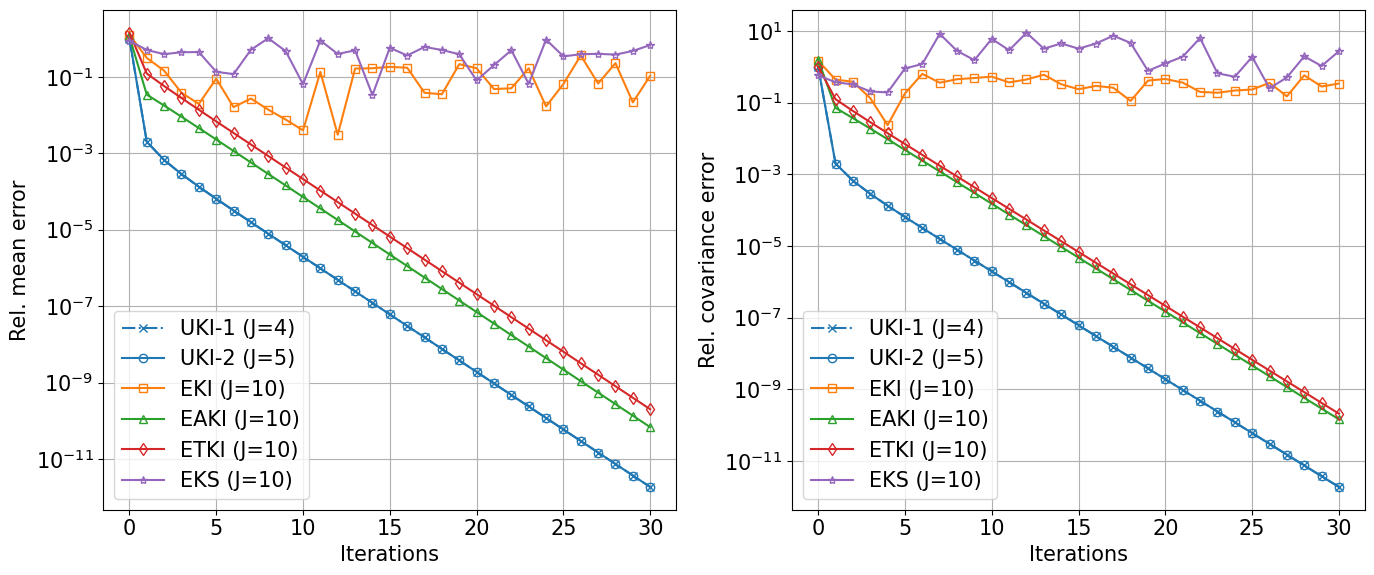

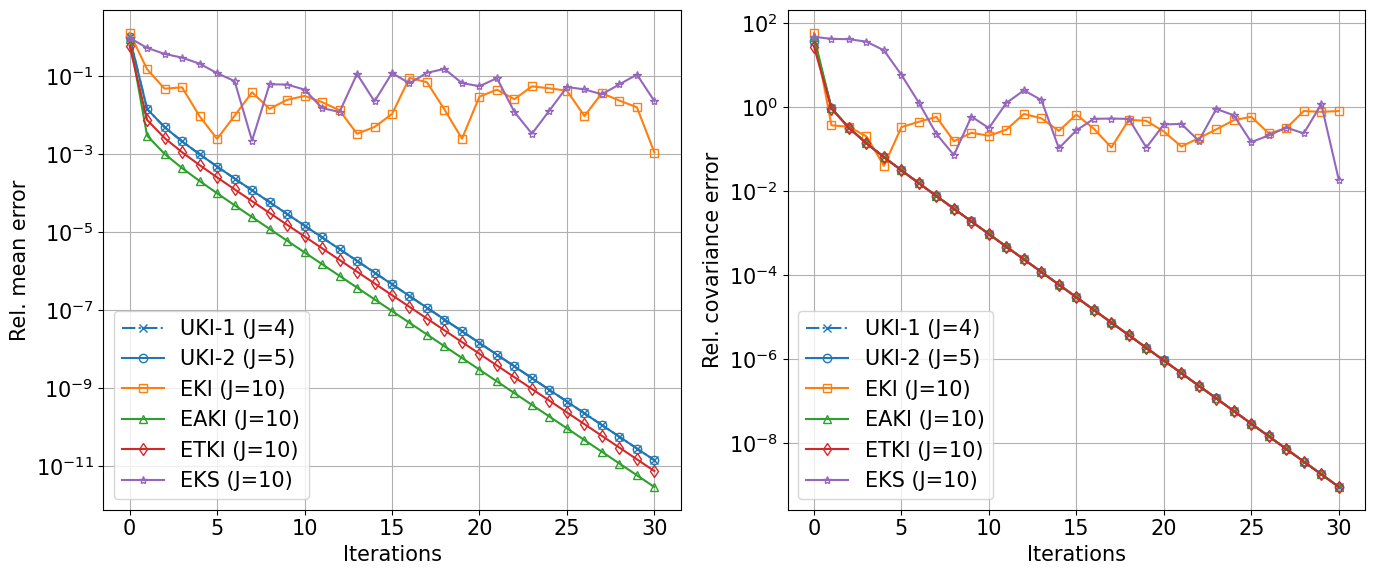

┌ Info: To use the original EKI, uncomment EKI.jl line 88-89
└ @ Main In[4]:58
┌ Info: ("EKS small J t = ", 25.376158785668487)
└ @ Main In[4]:129
┌ Info: ("EKS large J t = ", 25.376158785668487)
└ @ Main In[4]:138


In [4]:
FT = Float64
uki_objs = Dict()
mean_errors = Dict()

Random.seed!(123)
α_reg = 1.0
update_freq = 1
N_iter = 30
N_θ = 2
θ0_mean = zeros(FT, N_θ)
θθ0_cov = Array(Diagonal(fill(1.0^2, N_θ)))
θθ0_cov_sqrt = θθ0_cov
unscented_transform = "modified-n+2"
for problem_type in ("under-determined", "over-determined")
    
    θ_post, Σ_post, G, y, Σ_η = Two_Param_Linear_Test(problem_type, θ0_mean, θθ0_cov)
    
    N_y = length(y)
    
    s_param = Setup_Param(G, N_θ, N_y)
    s_param_aug = Setup_Param(G, N_θ, N_y+N_θ)
    
        
    y_aug = [y ;θ0_mean]
    Σ_η_aug = [Σ_η zeros(Float64, N_y, N_θ); zeros(Float64, N_θ, N_y)  θθ0_cov]
 
    # UKI
    uki_obj = UKI_Run(s_param_aug, forward_aug, 
    θ0_mean, θθ0_cov,
    y_aug, Σ_η_aug,
    α_reg,
    update_freq,
    N_iter;
    unscented_transform=unscented_transform)
    
    # UKI
    uki_2np1_obj = UKI_Run(s_param_aug, forward_aug, 
    θ0_mean, θθ0_cov,
    y_aug, Σ_η_aug,
    α_reg,
    update_freq,
    N_iter;
    unscented_transform="modified-2n+1")
    
    original  = false
    eki_y = (original ? y : y_aug)
    eki_Σ_η = (original ? Σ_η : Σ_η_aug)
    eki_s_param = (original ? s_param : s_param_aug)
    eki_forward = (original ? forward : forward_aug) 
    
    
    N_θ_s = 5
    N_θ_l = 10
    
    γ_ω = (original ? 0.0 : 1.0)  
    γ_η = ( original ? 1.0 : (γ_ω + 1)/γ_ω ) 
    # EKI
    @info "To use the original EKI, uncomment EKI.jl line 88-89"
    filter_type = "EKI"
    N_ens = N_θ_s
    eki_obj_s = EKI_Run(eki_s_param, eki_forward, 
    filter_type,
    θ0_mean, θθ0_cov_sqrt,
    N_ens,
    eki_y, eki_Σ_η,
    γ_ω, γ_η,
    N_iter)
    
    N_ens = N_θ_l
    eki_obj_l = EKI_Run(eki_s_param, eki_forward, 
    filter_type,
    θ0_mean, θθ0_cov_sqrt,
    N_ens,
    eki_y, eki_Σ_η,
    γ_ω, γ_η,
    N_iter)
    
    # ETKI
    filter_type = "ETKI"
    N_ens = N_θ_s
    etki_obj_s = EKI_Run(eki_s_param, eki_forward, 
    filter_type,
    θ0_mean, θθ0_cov_sqrt,
    N_ens,
    eki_y, eki_Σ_η,
    γ_ω, γ_η,
    N_iter)
    
    N_ens = N_θ_l
    etki_obj_l = EKI_Run(eki_s_param, eki_forward, 
    filter_type,
    θ0_mean, θθ0_cov_sqrt,
    N_ens,
    eki_y, eki_Σ_η,
    γ_ω, γ_η,
    N_iter)
    
    
    # EAKI
    filter_type = "EAKI"
    N_ens = N_θ_s
    eaki_obj_s = EKI_Run(eki_s_param, eki_forward, 
    filter_type,
    θ0_mean, θθ0_cov_sqrt,
    N_ens,
    eki_y, eki_Σ_η,
    γ_ω, γ_η,
    N_iter)
    
    
    N_ens = N_θ_l
    eaki_obj_l = EKI_Run(eki_s_param, eki_forward, 
    filter_type,
    θ0_mean, θθ0_cov_sqrt,
    N_ens,
    eki_y, eki_Σ_η,
    γ_ω, γ_η,
    N_iter)
    
    
    # EKS
    N_ens = N_θ_s
    eks_obj_s = EKS_Run(s_param, forward, 
    θ0_mean, θθ0_cov,
    N_ens,
    y, Σ_η,
    N_iter)
    
    @info "EKS small J t = ", sum(eks_obj_s.Δt)
    
    N_ens = N_θ_l
    eks_obj_l = EKS_Run(s_param, forward, 
    θ0_mean, θθ0_cov,
    N_ens,
    y, Σ_η,
    N_iter)
    
    @info "EKS large J t = ", sum(eks_obj_s.Δt)
    
    
    
    uki_errors    = zeros(FT, N_iter+1, 2)
    uki_2np1_errors = zeros(FT, N_iter+1, 2)
    eki_s_errors  = zeros(FT, N_iter+1, 2)
    eki_l_errors  = zeros(FT, N_iter+1, 2)
    eaki_s_errors = zeros(FT, N_iter+1, 2)
    eaki_l_errors = zeros(FT, N_iter+1, 2)
    etki_s_errors = zeros(FT, N_iter+1, 2)
    etki_l_errors = zeros(FT, N_iter+1, 2)
    eks_s_errors  = zeros(FT, N_iter+1, 2)
    eks_l_errors  = zeros(FT, N_iter+1, 2)
    
    for i = 1:N_iter+1
        uki_errors[i, 1] = norm(uki_obj.θ_mean[i] .- θ_post)/norm(θ_post)
        uki_errors[i, 2] = norm(uki_obj.θθ_cov[i] .- Σ_post)/norm(Σ_post)
        
        uki_2np1_errors[i, 1] = norm(uki_2np1_obj.θ_mean[i] .- θ_post)/norm(θ_post)
        uki_2np1_errors[i, 2] = norm(uki_2np1_obj.θθ_cov[i] .- Σ_post)/norm(Σ_post)
        
        eki_s_errors[i, 1] = norm(dropdims(mean(eki_obj_s.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        eki_s_errors[i, 2] = norm(construct_cov(eki_obj_s.θ[i]) .- Σ_post)/norm(Σ_post)
        
        eki_l_errors[i, 1] = norm(dropdims(mean(eki_obj_l.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        eki_l_errors[i, 2] = norm(construct_cov(eki_obj_l.θ[i]) .- Σ_post)/norm(Σ_post)
        
        eaki_s_errors[i, 1] = norm(dropdims(mean(eaki_obj_s.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        eaki_s_errors[i, 2] = norm(construct_cov(eaki_obj_s.θ[i]) .- Σ_post)/norm(Σ_post)
        
        eaki_l_errors[i, 1] = norm(dropdims(mean(eaki_obj_l.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        eaki_l_errors[i, 2] = norm(construct_cov(eaki_obj_l.θ[i]) .- Σ_post)/norm(Σ_post)
        
        etki_s_errors[i, 1] = norm(dropdims(mean(etki_obj_s.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        etki_s_errors[i, 2] = norm(construct_cov(etki_obj_s.θ[i]) .- Σ_post)/norm(Σ_post)
        
        etki_l_errors[i, 1] = norm(dropdims(mean(etki_obj_l.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        etki_l_errors[i, 2] = norm(construct_cov(etki_obj_l.θ[i]) .- Σ_post)/norm(Σ_post)
        
        eks_s_errors[i, 1] = norm(dropdims(mean(eks_obj_s.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        eks_s_errors[i, 2] = norm(construct_cov(eks_obj_s.θ[i]) .- Σ_post)/norm(Σ_post)
        
        eks_l_errors[i, 1] = norm(dropdims(mean(eks_obj_l.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        eks_l_errors[i, 2] = norm(construct_cov(eks_obj_l.θ[i]) .- Σ_post)/norm(Σ_post)
        
    end
    
    ites = Array(0:N_iter)
    

    
    
    fig, ax = PyPlot.subplots(nrows = 1, ncols=2, sharex=false, sharey=false, figsize=(14,6))
    ax[1].semilogy(ites, uki_errors[:, 1],   "-.x", color = "C0", fillstyle="none", label="UKI-1 (J=$(N_θ+2))")
    ax[1].semilogy(ites, uki_2np1_errors[:, 1],   "-o", color = "C0", fillstyle="none", label="UKI-2 (J=$(2*N_θ+1))")
    ax[1].semilogy(ites, eki_l_errors[:, 1], "-s", color = "C1", fillstyle="none", label="EKI (J=$N_θ_l)")
    ax[1].semilogy(ites, eaki_l_errors[:, 1], "-^", color = "C2", fillstyle="none", label="EAKI (J=$N_θ_l)")
    ax[1].semilogy(ites, etki_l_errors[:, 1], "-d", color = "C3", fillstyle="none", label="ETKI (J=$N_θ_l)")
    ax[1].semilogy(ites, eks_l_errors[:, 1], "-*", color = "C4", fillstyle="none", label="EKS (J=$N_θ_l)")
    ax[1].set_xlabel("Iterations")
    ax[1].set_ylabel("Rel. mean error")
    ax[1].grid("on")
    ax[1].legend()
    
    ax[2].semilogy(ites, uki_errors[:, 2],   "-.x", color = "C0", fillstyle="none", label="UKI-1 (J=$(N_θ+2))")
    ax[2].semilogy(ites, uki_2np1_errors[:, 2],   "-o", color = "C0", fillstyle="none", label="UKI-2 (J=$(2*N_θ+1))")
    ax[2].semilogy(ites, eki_l_errors[:, 2], "-s", color = "C1", fillstyle="none", label="EKI (J=$N_θ_l)")
    ax[2].semilogy(ites, eaki_l_errors[:, 2], "-^", color = "C2", fillstyle="none", label="EAKI (J=$N_θ_l)")
    ax[2].semilogy(ites, etki_l_errors[:, 2], "-d", color = "C3", fillstyle="none", label="ETKI (J=$N_θ_l)")
    ax[2].semilogy(ites, eks_l_errors[:, 2], "-*", color = "C4", fillstyle="none", label="EKS (J=$N_θ_l)")
    ax[2].set_xlabel("Iterations")
    ax[2].set_ylabel("Rel. covariance error")
    ax[2].grid("on")
    ax[2].legend()
    fig.tight_layout()
    fig.savefig("Linear-$(problem_type).pdf")
end



┌ Info: To use the original EKI, uncomment EKI.jl line 88-89
└ @ Main In[5]:61


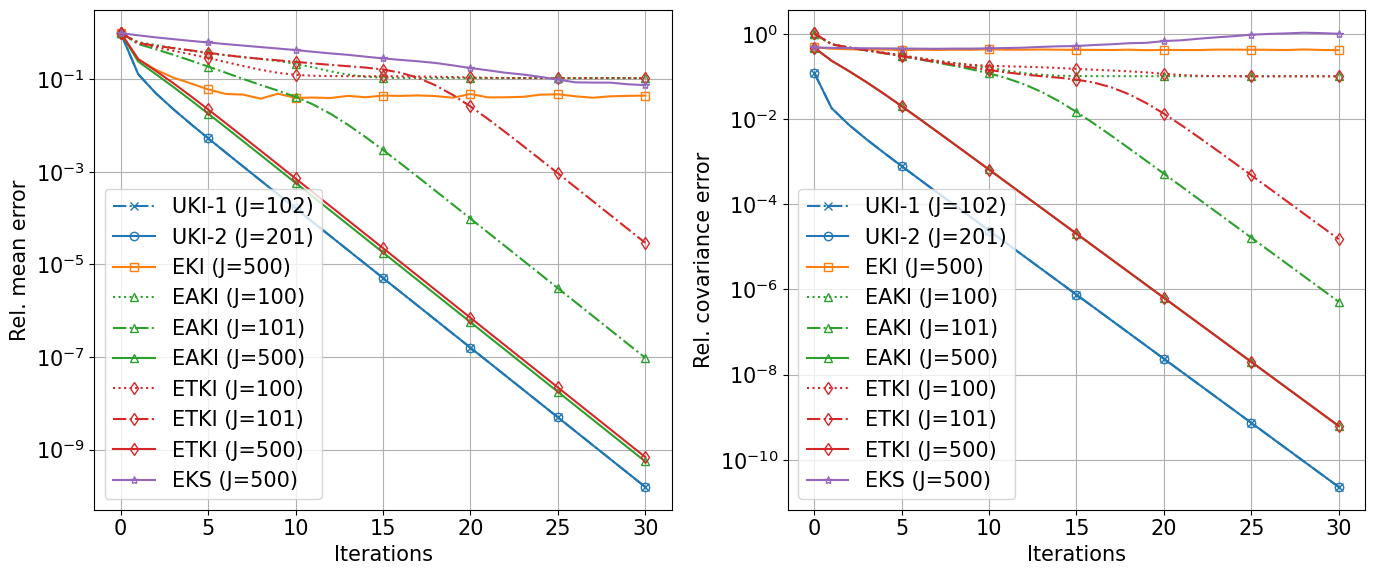

┌ Info: ("EKS large J t = ", 4.6046344005039)
└ @ Main In[5]:140


In [5]:
FT = Float64
uki_objs = Dict()
mean_errors = Dict()

Random.seed!(41)
α_reg = 1.0
update_freq = 1
N_iter = 30
N_θ = 100
θ0_mean = zeros(FT, N_θ)
θθ0_cov = Array(Diagonal(fill(1.0^2, N_θ)))
θθ0_cov_sqrt = θθ0_cov

unscented_transform = "modified-n+2"

for problem_type in ("Hilbert", )
    
    θ_post, Σ_post, G, y, Σ_η = Two_Param_Linear_Test(problem_type, θ0_mean, θθ0_cov)
    
    N_y = length(y)
    
    s_param = Setup_Param(G, N_θ, N_y)
    s_param_aug = Setup_Param(G, N_θ, N_y+N_θ)
    
        
    y_aug = [y ;θ0_mean]
    Σ_η_aug = [Σ_η zeros(Float64, N_y, N_θ); zeros(Float64, N_θ, N_y)  θθ0_cov]
 
    # UKI
    uki_obj = UKI_Run(s_param_aug, forward_aug, 
    θ0_mean, θθ0_cov,
    y_aug, Σ_η_aug,
    α_reg,
    update_freq,
    N_iter,
    unscented_transform = unscented_transform )
 
    # UKI 2np1
    uki_2np1_obj = UKI_Run(s_param_aug, forward_aug, 
    θ0_mean, θθ0_cov,
    y_aug, Σ_η_aug,
    α_reg,
    update_freq,
    N_iter,
    unscented_transform = "modified-2n+1" )
    
    original  = false
    eki_y = (original ? y : y_aug)
    eki_Σ_η = (original ? Σ_η : Σ_η_aug)
    eki_s_param = (original ? s_param : s_param_aug)
    eki_forward = (original ? forward : forward_aug) 
    
    
    N_θ_s = N_θ
    N_θ_m = N_θ+1
    N_θ_l = 500
    
    γ_ω = (original ? 0.0 : 1.0)  
    γ_η = ( original ? 1.0 : (γ_ω + 1)/γ_ω ) 
    # EKI
    @info "To use the original EKI, uncomment EKI.jl line 88-89"
    filter_type = "EKI"
    N_ens = N_θ_l
    eki_obj_l = EKI_Run(eki_s_param, eki_forward, 
    filter_type,
    θ0_mean, θθ0_cov_sqrt,
    N_ens,
    eki_y, eki_Σ_η,
    γ_ω, γ_η,
    N_iter)
    
    # ETKI
    filter_type = "ETKI"
    N_ens = N_θ_s
    etki_obj_s = EKI_Run(eki_s_param, eki_forward, 
    filter_type,
    θ0_mean, θθ0_cov_sqrt,
    N_ens,
    eki_y, eki_Σ_η,
    γ_ω, γ_η,
    N_iter)
    
    N_ens = N_θ_m
    etki_obj_m = EKI_Run(eki_s_param, eki_forward, 
    filter_type,
    θ0_mean, θθ0_cov_sqrt,
    N_ens,
    eki_y, eki_Σ_η,
    γ_ω, γ_η,
    N_iter)
    
    N_ens = N_θ_l
    etki_obj_l = EKI_Run(eki_s_param, eki_forward, 
    filter_type,
    θ0_mean, θθ0_cov_sqrt,
    N_ens,
    eki_y, eki_Σ_η,
    γ_ω, γ_η,
    N_iter)
    
    
    # EAKI
    filter_type = "EAKI"
    N_ens = N_θ_s
    eaki_obj_s = EKI_Run(eki_s_param, eki_forward, 
    filter_type,
    θ0_mean, θθ0_cov_sqrt,
    N_ens,
    eki_y, eki_Σ_η,
    γ_ω, γ_η,
    N_iter)

    N_ens = N_θ_m
    eaki_obj_m = EKI_Run(eki_s_param, eki_forward, 
    filter_type,
    θ0_mean, θθ0_cov_sqrt,
    N_ens,
    eki_y, eki_Σ_η,
    γ_ω, γ_η,
    N_iter)
    
    N_ens = N_θ_l
    eaki_obj_l = EKI_Run(eki_s_param, eki_forward, 
    filter_type,
    θ0_mean, θθ0_cov_sqrt,
    N_ens,
    eki_y, eki_Σ_η,
    γ_ω, γ_η,
    N_iter)
    
    
    # EKS
    N_ens = N_θ_l
    eks_obj_l = EKS_Run(s_param, forward, 
    θ0_mean, θθ0_cov,
    N_ens,
    y, Σ_η,
    N_iter)
    
    @info "EKS large J t = ", sum(eks_obj_l.Δt)
    
    uki_errors    = zeros(FT, N_iter+1, 2)
    uki_2np1_errors    = zeros(FT, N_iter+1, 2)
    eki_l_errors  = zeros(FT, N_iter+1, 2)
    eaki_s_errors = zeros(FT, N_iter+1, 2)
    eaki_m_errors = zeros(FT, N_iter+1, 2)
    eaki_l_errors = zeros(FT, N_iter+1, 2)
    etki_s_errors = zeros(FT, N_iter+1, 2)
    etki_m_errors = zeros(FT, N_iter+1, 2)
    etki_l_errors = zeros(FT, N_iter+1, 2)
    eks_l_errors  = zeros(FT, N_iter+1, 2)
    
    for i = 1:N_iter+1
        uki_errors[i, 1] = norm(uki_obj.θ_mean[i] .- θ_post)/norm(θ_post)
        uki_errors[i, 2] = norm(uki_obj.θθ_cov[i] .- Σ_post)/norm(Σ_post)
          
        uki_2np1_errors[i, 1] = norm(uki_2np1_obj.θ_mean[i] .- θ_post)/norm(θ_post)
        uki_2np1_errors[i, 2] = norm(uki_2np1_obj.θθ_cov[i] .- Σ_post)/norm(Σ_post)
        
        eki_l_errors[i, 1] = norm(dropdims(mean(eki_obj_l.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        eki_l_errors[i, 2] = norm(construct_cov(eki_obj_l.θ[i]) .- Σ_post)/norm(Σ_post)
        
        eaki_s_errors[i, 1] = norm(dropdims(mean(eaki_obj_s.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        eaki_s_errors[i, 2] = norm(construct_cov(eaki_obj_s.θ[i]) .- Σ_post)/norm(Σ_post)
        
        eaki_m_errors[i, 1] = norm(dropdims(mean(eaki_obj_m.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        eaki_m_errors[i, 2] = norm(construct_cov(eaki_obj_m.θ[i]) .- Σ_post)/norm(Σ_post)
        
        eaki_l_errors[i, 1] = norm(dropdims(mean(eaki_obj_l.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        eaki_l_errors[i, 2] = norm(construct_cov(eaki_obj_l.θ[i]) .- Σ_post)/norm(Σ_post)
        
        etki_s_errors[i, 1] = norm(dropdims(mean(etki_obj_s.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        etki_s_errors[i, 2] = norm(construct_cov(etki_obj_s.θ[i]) .- Σ_post)/norm(Σ_post)
        
        etki_m_errors[i, 1] = norm(dropdims(mean(etki_obj_m.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        etki_m_errors[i, 2] = norm(construct_cov(etki_obj_m.θ[i]) .- Σ_post)/norm(Σ_post)
        
        etki_l_errors[i, 1] = norm(dropdims(mean(etki_obj_l.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        etki_l_errors[i, 2] = norm(construct_cov(etki_obj_l.θ[i]) .- Σ_post)/norm(Σ_post)
        
        eks_l_errors[i, 1] = norm(dropdims(mean(eks_obj_l.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        eks_l_errors[i, 2] = norm(construct_cov(eks_obj_l.θ[i]) .- Σ_post)/norm(Σ_post)
        
    end
    
    ites = Array(0:N_iter)
    mkevery = 5
    fig, ax = PyPlot.subplots(nrows = 1, ncols=2, sharex=false, sharey=false, figsize=(14,6))
    ax[1].semilogy(ites, uki_errors[:, 1],   "-.x", color = "C0", fillstyle="none", label="UKI-1 (J=$(N_θ+2))", markevery = mkevery)
    ax[1].semilogy(ites, uki_2np1_errors[:, 1],   "-o", color = "C0", fillstyle="none", label="UKI-2 (J=$(2*N_θ+1))", markevery = mkevery)
    ax[1].semilogy(ites, eki_l_errors[:, 1], "-s", color = "C1", fillstyle="none", label="EKI (J=$(N_θ_l))", markevery = mkevery)
    ax[1].semilogy(ites, eaki_s_errors[:, 1], ":^", color = "C2", fillstyle="none", label="EAKI (J=$(N_θ_s))", markevery = mkevery)
    ax[1].semilogy(ites, eaki_m_errors[:, 1], "-.^", color = "C2", fillstyle="none", label="EAKI (J=$(N_θ_m))", markevery = mkevery)
    ax[1].semilogy(ites, eaki_l_errors[:, 1], "-^", color = "C2", fillstyle="none", label="EAKI (J=$(N_θ_l))", markevery = mkevery)
    ax[1].semilogy(ites, etki_s_errors[:, 1], ":d", color = "C3", fillstyle="none", label="ETKI (J=$(N_θ_s))", markevery = mkevery)
    ax[1].semilogy(ites, etki_m_errors[:, 1], "-.d", color = "C3", fillstyle="none", label="ETKI (J=$(N_θ_m))", markevery = mkevery)
    ax[1].semilogy(ites, etki_l_errors[:, 1], "-d", color = "C3", fillstyle="none", label="ETKI (J=$(N_θ_l))", markevery = mkevery)
    ax[1].semilogy(ites, eks_l_errors[:, 1], "-*", color = "C4", fillstyle="none", label="EKS (J=$(N_θ_l))", markevery = mkevery)
    ax[1].set_xlabel("Iterations")
    ax[1].set_ylabel("Rel. mean error")
    ax[1].grid("on")
    ax[1].legend()
    
    ax[2].semilogy(ites, uki_errors[:, 2],   "-.x", color = "C0", fillstyle="none", label="UKI-1 (J=$(N_θ+2))", markevery = mkevery)
    ax[2].semilogy(ites, uki_2np1_errors[:, 2],   "-o", color = "C0", fillstyle="none", label="UKI-2 (J=$(2*N_θ+1))", markevery = mkevery)
    ax[2].semilogy(ites, eki_l_errors[:, 2], "-s", color = "C1", fillstyle="none", label="EKI (J=$(N_θ_l))", markevery = mkevery)
    ax[2].semilogy(ites, eaki_s_errors[:, 2], ":^", color = "C2", fillstyle="none", label="EAKI (J=$(N_θ_s))", markevery = mkevery)
    ax[2].semilogy(ites, eaki_m_errors[:, 2], "-.^", color = "C2", fillstyle="none", label="EAKI (J=$(N_θ_m))", markevery = mkevery)
    ax[2].semilogy(ites, eaki_l_errors[:, 2], "-^", color = "C2", fillstyle="none", label="EAKI (J=$(N_θ_l))", markevery = mkevery)
    ax[2].semilogy(ites, etki_s_errors[:, 2], ":d", color = "C3", fillstyle="none", label="ETKI (J=$(N_θ_s))", markevery = mkevery)
    ax[2].semilogy(ites, etki_m_errors[:, 2], "-.d", color = "C3", fillstyle="none", label="ETKI (J=$(N_θ_m))", markevery = mkevery)
    ax[2].semilogy(ites, etki_l_errors[:, 2], "-d", color = "C3", fillstyle="none", label="ETKI (J=$(N_θ_l))", markevery = mkevery)
    ax[2].semilogy(ites, eks_l_errors[:, 2], "-*", color = "C4", fillstyle="none", label="EKS (J=$(N_θ_l))", markevery = mkevery)
    ax[2].set_xlabel("Iterations")
    ax[2].set_ylabel("Rel. covariance error")
    ax[2].grid("on")
    ax[2].legend()
    fig.tight_layout()
    fig.savefig("Hilbert-$(problem_type).pdf")
end


